In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc
import pickle
from tqdm import tqdm
import proplot as pplt

# from ip3_ca_ode import *
from ip3_ca_ode_cfg import *
import cfg
import os
import pandas as pd

save = 'figures/paper_plots/falloff/'

pplt.rc.update({'font.size': 10})
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
'''Plateau functions'''

def report_max_ratios(times=[0, 100, 160, 300], var='c'):
    '''
    Report the max values and ratio of maxes for a variable in the time frames given
    Times should always be a list of 4 integers giving two time intervals to measure maxes from
    Returns:
        ratio of second max to first max (e.g. if second max is 50% of first, return 0.5)
        list of max values reported
        list of index location of max values (for plotting)
    '''
    indices = [np.argmax(cfg.t > t) for t in times]
    if indices[-1] == 0:
        indices[-1] = -1
    y = getattr(cfg, var)
    
    maxes = []
    pos = []
    for i in range(2):
        low = indices[i*2]
        high = indices[i*2 + 1]
        
        ymax = np.max(y[low:high])
        maxpos = np.argmax(y[low:high])
        
        pos.append(maxpos + low)
        maxes.append(ymax)
        
    ratio = maxes[1] / maxes[0]
    return ratio, maxes, pos

def slope_at_index(idx, var='c'):
    y = getattr(cfg, var)
    t2 = cfg.t[idx + 1]
    t1 = cfg.t[idx - 1]
    y2 = y[idx + 1]
    y1 = y[idx - 1]
    return (y2 - y1) / (t2 - t1)


def conditional_double_bath(glut=0.4, first=240, rest=310, mod=0, noise=False,
                           force_run=False):
    '''
    get experimental double bath c ratio from globals()['df'] if it is loaded
    otherwise run and save
    '''
    if 'df' in globals()['df']:
        df = globals()['df']
    else:
        df = pd.read_pickle('data/experiments/double_bath/dataframe')
        globals()['df'] = df
    
    df = df[df['glut'] == glut]
    df = df[df['first'] == first]
    df = df[df['rest'] == rest]
    df = df[df['mod'] == mod]
    df = df[df['noise'] == noise]
    
    kd1 = 0.02
    kd2 = 0.6
    
    #if no such experiment found, run it and save the results
    if len(df) == 0 or force_run:
        set_init()
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_vals = [0, glut, 0, glut, 0]
        cfg.kd1 = kd1 * mod
        cfg.kd2 = kd2 * mod
        sol = run_experiment('custom', t_f=80+first+rest, max_step=0.1)
        ratio, _, _ = report_max_ratios(times=ratio_times)
        
        df_row = pd.DataFrame([{
            'glut': glut,
            'first': first,
            'rest': rest,
            'mod': mod,
            'noise': noise,
            'ratio': ratio
        }], columns=['glut','first','rest','mod','noise','ratio'])
        df = pd.read_pickle('data/experiments/double_bath/dataframe')
        df = df.append(df_row, ignore_index=True)
        df.to_pickle('data/experiments/double_bath/dataframe')
        globals()['df'] = df
        return ratio
    else:
        ratio = df.iloc[0]['ratio']
        return ratio
    
    
def capture_c(t):
    '''
    get c at values of t
    '''
    idx = np.argmax(cfg.t >= t)
    c = cfg.c[idx]
    return c



'''Oscillation functions'''

def get_peaks():
    peaks = scipy.signal.find_peaks(cfg.c)[0]
    return_low_lim = 0.2 #how far does calcium have to return before we consider
                         #ourselves to be in standard oscillation range
    first_peak = peaks[0]
    # return_low = np.argmax(cfg.c[first_peak:] < return_low_lim)
    # if return_low == 0:
    #     osc_start = -1
    # else:
    #     osc_start = first_peak + return_low
    # peaks = np.append([first_peak], scipy.signal.find_peaks(cfg.c[osc_start:])[0] + osc_start)
    c_peaks = cfg.c[peaks]
    t_peaks = cfg.t[peaks]
    
    return t_peaks, c_peaks
        


# Shared visual example

Text(0, 0.5, '[Ca$^{2+}$]$_{cyt}$')

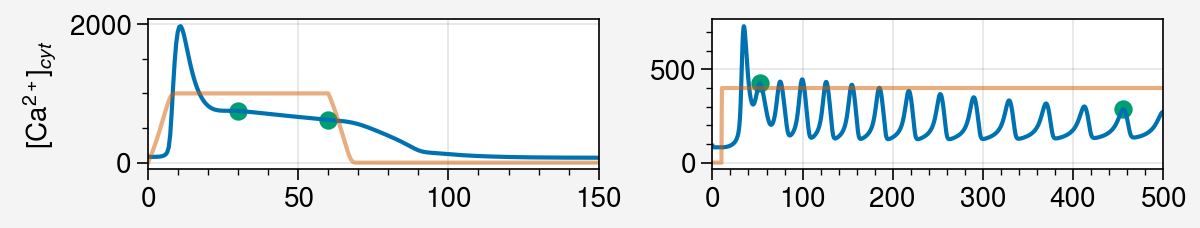

In [17]:
fig, ax = pplt.subplots(ncols=2, refaspect=3, figwidth=6, sharex=False, 
                        sharey=False)

set_init('c_t')
cfg.input_max = 20
cfg.input_start = 10
cfg.input_duration = 50
t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30

run_experiment('exponential_pulse', t_f=150, max_step=0.5)
ax[0].plot(cfg.t, cfg.c*1000)
ax[0].plot(cfg.t_input, cfg.glut * 50, alpha=0.5)
ax[0].scatter([t1, t2], [capture_c(t1)*1000, capture_c(t2)*1000])

cfg.input_start = 10
cfg.input_max = 0.8
cfg.input_duration = 1000

run_experiment('pulse', t_f=500, max_step=0.5)
t_peaks, c_peaks = get_peaks()

ax[1].plot(cfg.t, cfg.c*1000)
ax[1].plot(cfg.t_input, cfg.glut * 500, alpha=0.5)
# ax[1].scatter(t_peaks[1:], c_peaks[1:]*1000)
ax[1].scatter([t_peaks[1], t_peaks[-1]],
               [c_peaks[1]*1000, c_peaks[-1]*1000])

ax[0].set_ylabel(c_label)

# ax[0, 1].legend(bbox_to_anchor=(1, 1, 0, 0))
# ax[1, 0].set_xlabel('t')
# ax[0, 0].set_ylabel('[Ca$^{2+}$]$_{cyt}$ \n ($\mu$M)', rotation=0, labelpad=30)
# ax[0, 0].get_yaxis().set_label_coords(-0.4, -0.35)


# Plateau Falloff

## Parameter effects

### Visual examples of parameter effects

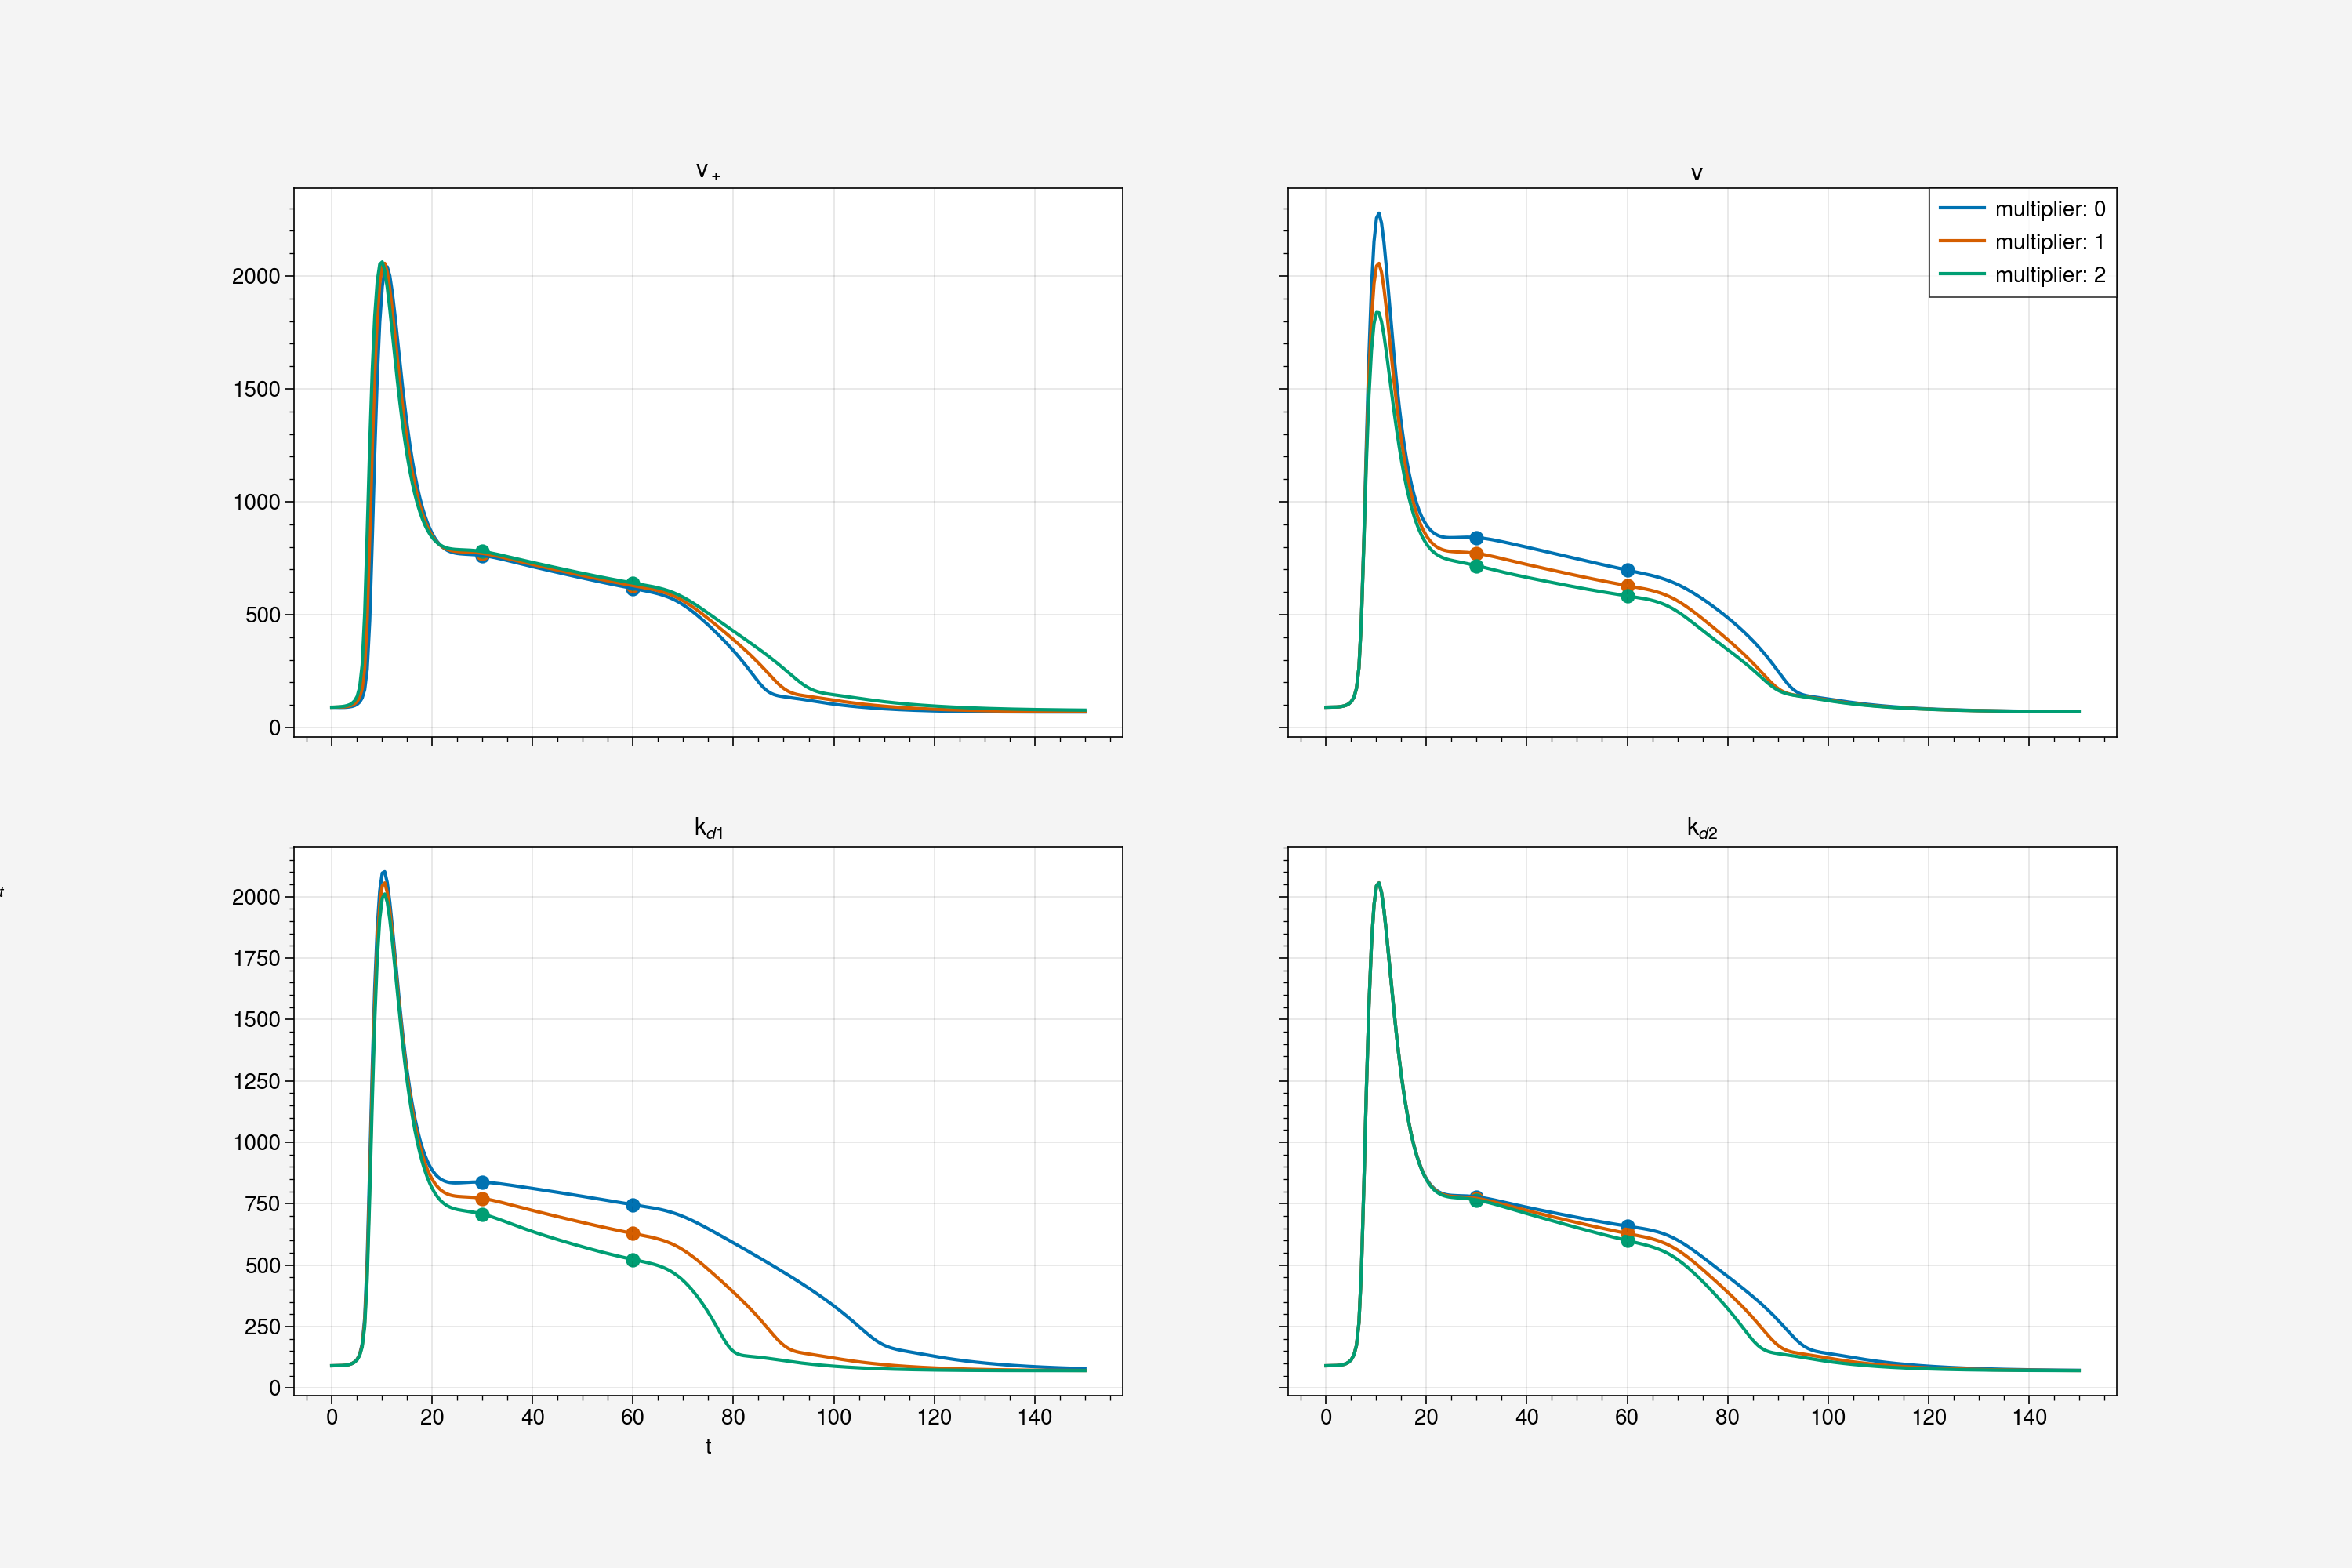

In [7]:
variables = ['v_delta', 'v_3k', 'kd1', 'kd2']
variable_labels = ['v$_+$', 'v$_-$', 'k$_{d1}$', 'k$_{d2}$']
default_vals = [getattr(cfg, var) for var in variables]
areas = {}
maxes = {}
c1s = {}
c2s = {}

cfg.input_max = 20
t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30

multipliers = np.linspace(0, 2, 3)
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharey='row', sharex=True)
for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    for mult in multipliers:
        setattr(cfg, var, default_vals[i] * mult)
        run_experiment('exponential_pulse', t_f=150, max_step=0.5)
        cfg.c = cfg.c * 1000
        ax[x, y].plot(cfg.t, cfg.c, label='multiplier: '+ str(int(mult)))
        ax[x, y].scatter([t1, t2], [capture_c(t1), capture_c(t2)])
    setattr(cfg, var, default_vals[i])
    ax[x, y].set_title(variable_labels[i])

ax[0, 1].legend(bbox_to_anchor=(1, 1, 0, 0))
ax[1, 0].set_xlabel('t')
ax[0, 0].set_ylabel('[Ca$^{2+}$]$_{cyt}$ \n ($\mu$M)', rotation=0, labelpad=30)
ax[0, 0].get_yaxis().set_label_coords(-0.4, -0.35)

# plt.tight_layout()
    
# plt.savefig(save + '1.2_visual_variable_example.png', bbox_inches='tight')

### Parameter effect data collection

In [17]:
variables = ['v_delta', 'v_3k', 'kd1', 'kd2']
variable_labels = ['v$_+$', 'v$_-$', 'k$_{d1}$', 'k$_{d2}$']
default_vals = [getattr(cfg, var) for var in variables]
areas = {}
maxes = {}
c1s = {}
c2s = {}

cfg.input_max = 20
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30


for var in variables:
    areas[var] = []
    maxes[var] = []
    c1s[var] = []
    c2s[var] = []
    
multipliers = np.linspace(0, 5, 51)
for i, var in enumerate(tqdm(variables)):
    for mult in multipliers:
        setattr(cfg, var, default_vals[i] * mult)
        run_experiment('exponential_pulse', t_f=250, max_step=0.5)
        maxes[var].append(cfg.c.max())
        areas[var].append(np.trapz(cfg.c, cfg.t))
        c1s[var].append(capture_c(t1))
        c2s[var].append(capture_c(t2))
    setattr(cfg, var, default_vals[i])

pickle.dump([c1s, c2s, multipliers], open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:30<00:00,  7.52s/it]


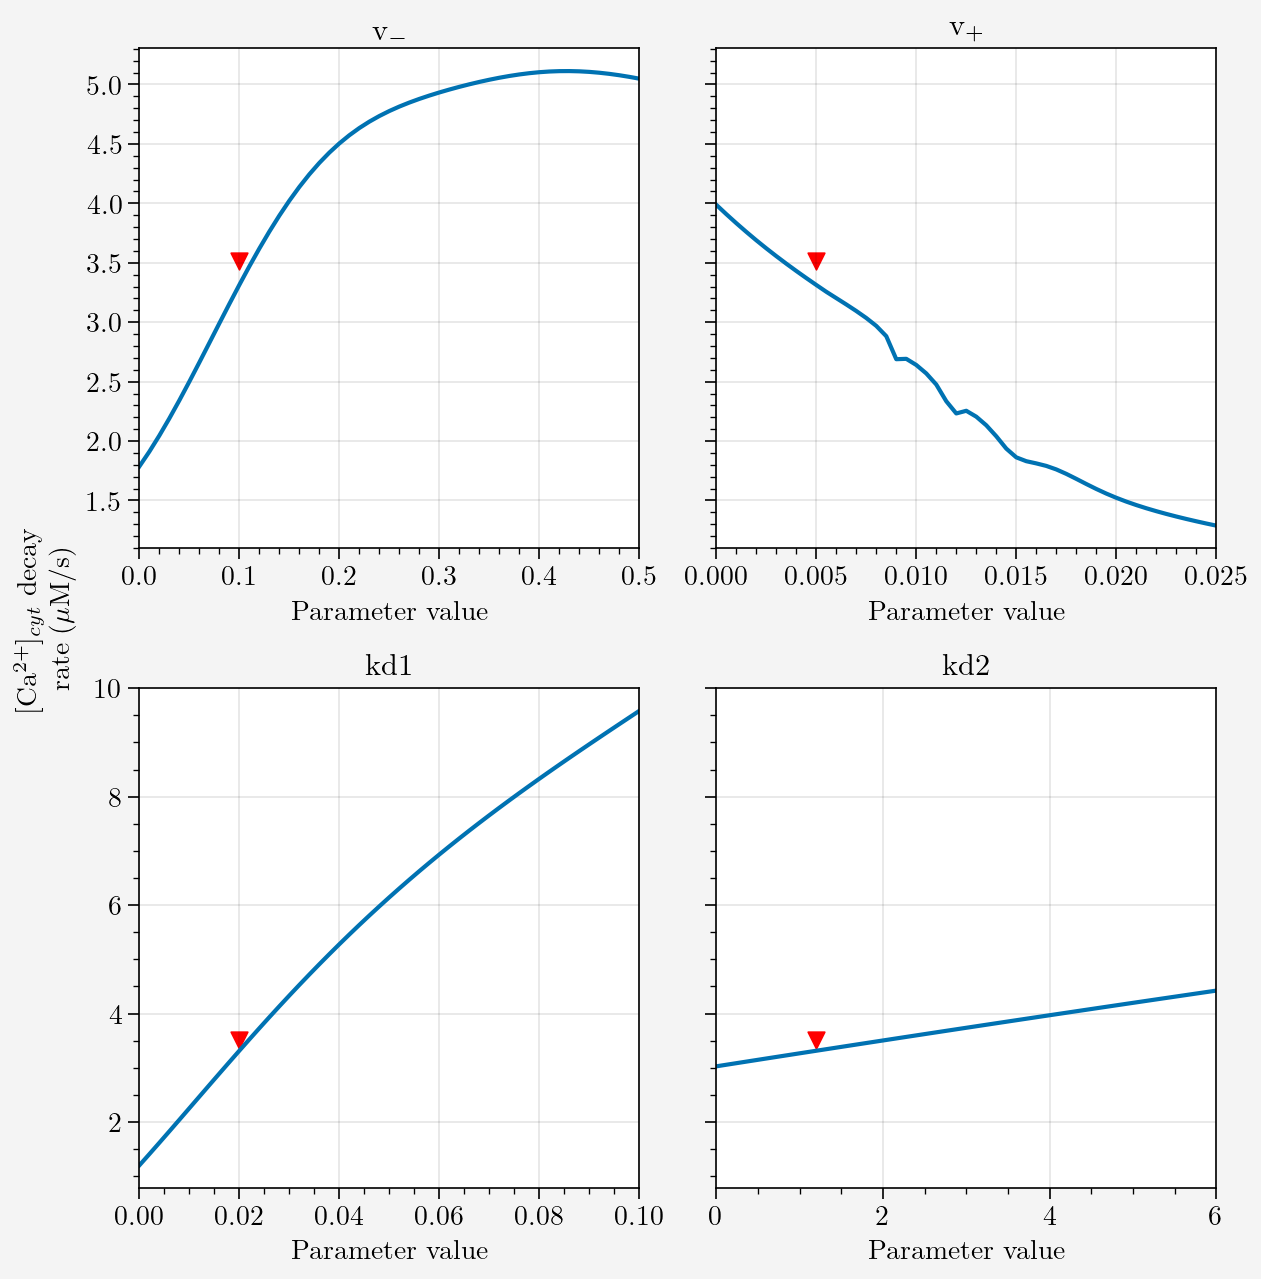

In [88]:
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
default_vals = [0.1, 0.005, 0.02, 1.2]


c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'rb'))
multipliers = np.linspace(0, 5, 51)

fig, ax = pplt.subplots(nrows=2, ncols=2, sharex=False)

for i, var in enumerate(variables):
    x = multipliers * default_vals[i]
    y = 1000*(np.array(c1s[var]) - np.array(c2s[var])) / (t2 - t1)
    
    ax[i].plot(x, y)
    ax[i].scatter(multipliers[10]*default_vals[i], y[10]+0.2,
                 c='red', marker='v')

ax.format(xlabel='Parameter value', ylabel='[Ca$^{2+}$]$_{cyt}$ decay\n rate ($\mu$M/s)',
          yrotation=0, title=labels)

### Parameter effect with fixed c_er time course

For consistency with ER plot, recollect same data using fixed c_er

In [18]:
'''Get fixed c_er'''
maxes2 = []
areas2 = []
c1s2 = []
c2s2 = []
cfg.input_max = 20

cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

run_experiment('exponential_pulse', t_f=250, max_step=0.5)
fix_c_er = cfg.c_er
t = cfg.t

mult = 1
inter = scipy.interpolate.interp1d(t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    # run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)

    
'''Data collection'''
variables = ['v_delta', 'v_3k', 'kd1', 'kd2']
variable_labels = ['v$_+$', 'v$_-$', 'k$_{d1}$', 'k$_{d2}$']
default_vals = [getattr(cfg, var) for var in variables]
areas = {}
maxes = {}
c1s = {}
c2s = {}

cfg.input_max = 20
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30


for var in variables:
    areas[var] = []
    maxes[var] = []
    c1s[var] = []
    c2s[var] = []
    
multipliers = np.linspace(0, 5, 51)
for i, var in enumerate(tqdm(variables)):
    for mult in multipliers:
        setattr(cfg, var, default_vals[i] * mult)
        run_experiment('exponential_pulse', t_f=250, max_step=0.5,
                      fix_c_er_func=inter)
        maxes[var].append(cfg.c.max())
        areas[var].append(np.trapz(cfg.c, cfg.t))
        c1s[var].append(capture_c(t1))
        c2s[var].append(capture_c(t2))
    setattr(cfg, var, default_vals[i])

pickle.dump([c1s, c2s, multipliers], open('data/plot_data/falloff/1.2_plateau_falloff_rate_fixedcer', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.49s/it]


## ER depletion effects

### Visual examples of ER depletion effects

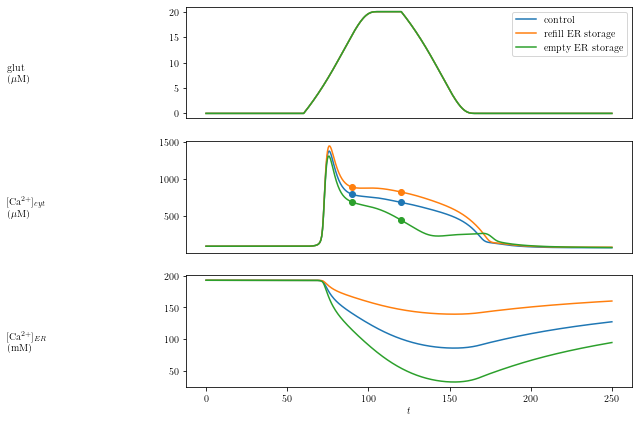

In [5]:
cfg.input_max = 20
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30


fig, ax = plt.subplots(3, 1, figsize=(8, 7))

run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax, legend_label='control')
fix_c_er = cfg.c_er
cfg.c = cfg.c*1000
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

mult = 0.5
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax, legend_label='refill ER storage')
cfg.c = cfg.c*1000
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

mult = 1.5
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['glut', 'c', 'c_er'], axs=ax, legend_label='empty ER storage')
cfg.c = cfg.c*1000
ax[1].scatter([t1, t2], [capture_c(t1), capture_c(t2)])

ax[0].legend(bbox_to_anchor=(1, 1, 0, 0))

# plt.savefig(save + '1.3_depletion_example.png', bbox_inches='tight')


### ER depletion effect data collection

In [7]:
maxes2 = []
areas2 = []
c1s2 = []
c2s2 = []
cfg.input_max = 20

cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

run_experiment('exponential_pulse', t_f=250, max_step=0.5)
fix_c_er = cfg.c_er
t = cfg.t

multipliers = np.linspace(0, 2, 51)
# multipliers = np.linspace(0, 2, 3)
for mult in tqdm(multipliers):
    inter = scipy.interpolate.interp1d(t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)

    maxes2.append(cfg.c.max())
    areas2.append(np.trapz(cfg.c, cfg.t))
    c1s2.append(capture_c(t1))
    c2s2.append(capture_c(t2))
    
pickle.dump([c1s2, c2s2, multipliers], open('data/plot_data/falloff/1.3_plateau_falloff_cer', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.56it/s]


## Comparison plot ER depletion vs kd1 vs v_3k

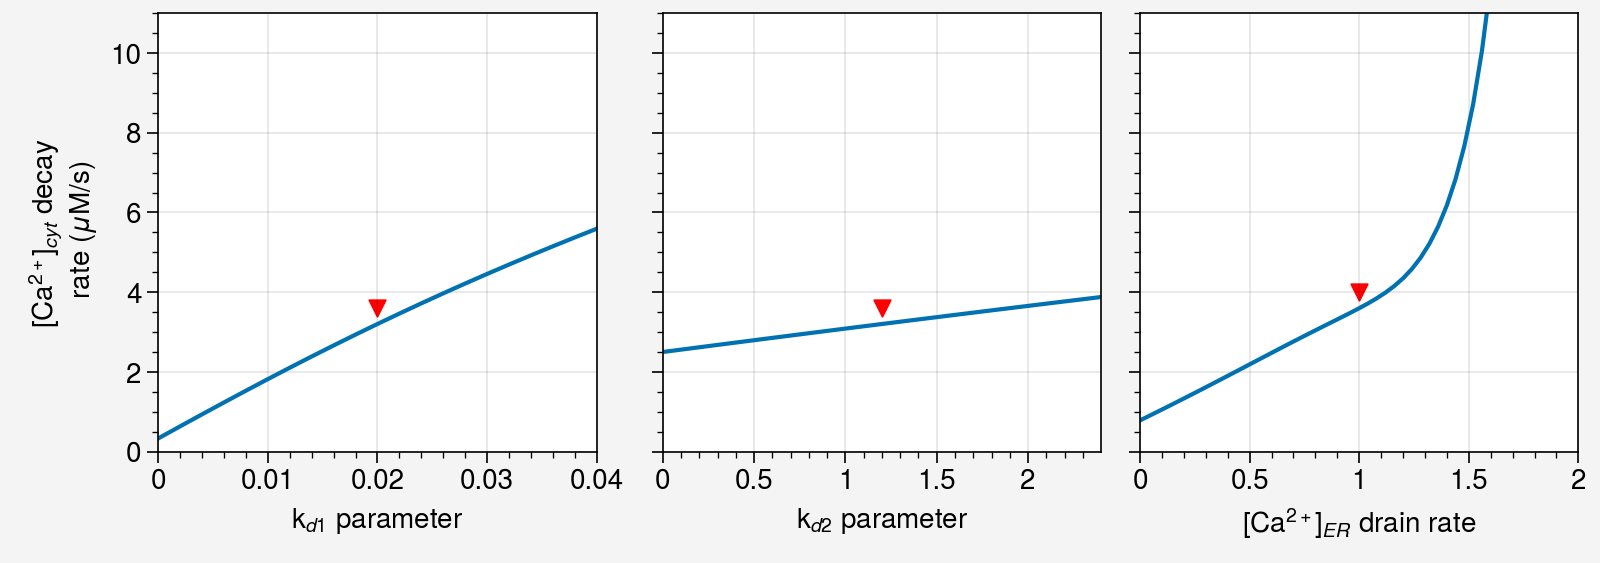

In [23]:
fig, ax = pplt.subplots(ncols=3, sharex=False, figwidth=8)

t1 = 65 - 50 + 30 #start - smoothing + partway through rampup time
t2 = t1 + 30 #30 seconds later

c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate_fixedcer', 'rb'))
c1s2, c2s2, _ = pickle.load(open('data/plot_data/falloff/1.3_plateau_falloff_cer', 'rb'))

#ER storage drain rate
ratios = 1000*(np.array(c1s2) - np.array(c2s2)) / (t2 - t1)
x = np.linspace(0, 2, 51)
ax[2].plot(x, ratios)
# ax[2].plot([1, 1], [0, 12], c='black', alpha=0.3)
ax[2].scatter(x[25], ratios[25]+0.4, c='red', marker='v')

#kd1, v- parameters
ratios = 1000*(np.array(c1s['kd1']) - np.array(c2s['kd1'])) / (t2 - t1)
x = np.linspace(0, 2, 21) * 0.02 #multipliers times default kd1 parameters
ax[0].plot(x, ratios[:21])
ax[0].scatter(x[10], ratios[10]+0.4, c='red', marker='v')


ratios = 1000*(np.array(c1s['kd2']) - np.array(c2s['kd2'])) / (t2 - t1)
x = np.linspace(0, 2, 21) * 1.2 #multipliers times default kd2 parameters
ax[1].plot(x, ratios[:21])
ax[1].scatter(x[10], ratios[10]+0.4, c='red', marker='v')

ax.format(ylabel='[Ca$^{2+}$]$_{cyt}$ decay\n rate ($\mu$M/s)',
          ylim=[0, 11])
ax[0].format(xlabel='k$_{d1}$ parameter')
ax[1].format(xlabel=r'k$_{d2}$ parameter')
ax[2].format(xlabel=r'[Ca$^{2+}$]$_{ER}$ drain rate')

# Oscillation Falloff

## Example

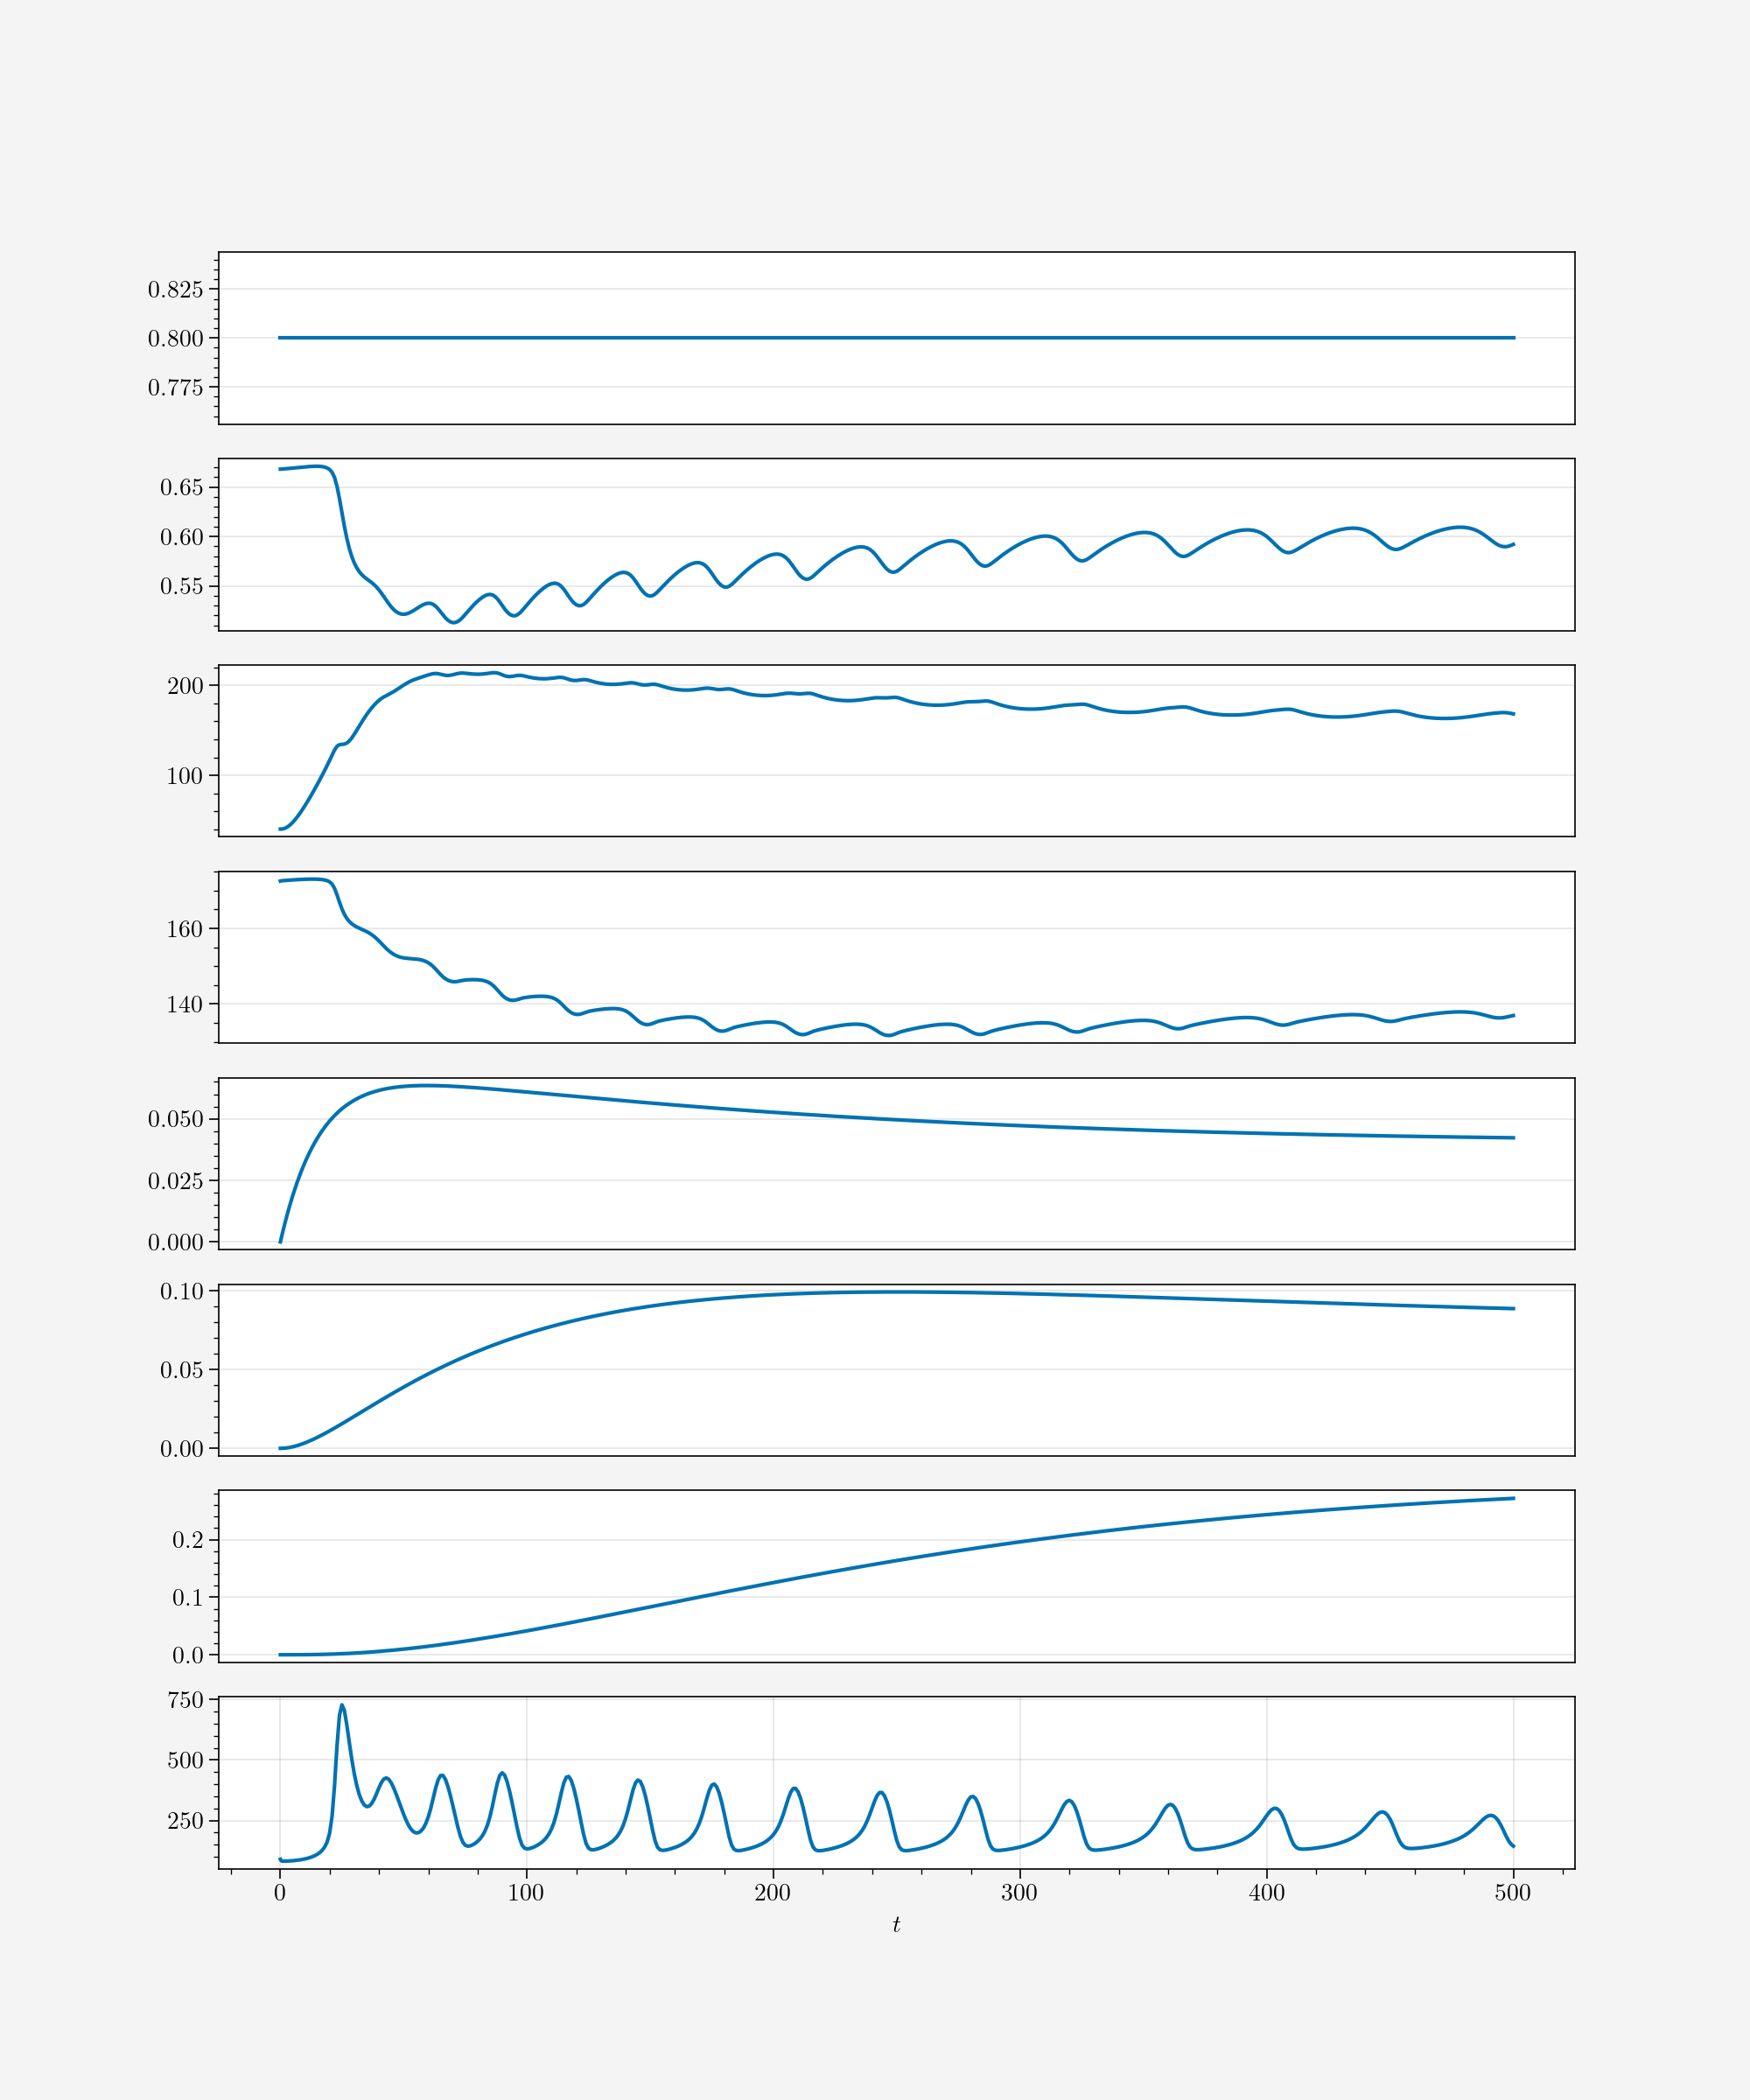

In [6]:
cfg.input_duration = 1000
cfg.input_max = 0.8
cfg.input_start = 0
fig, ax = plt.subplots(8, 1, figsize=(10, 12))
set_init('c_t')

run_experiment('exponential_pulse', t_f=500, max_step=1)

plot_experiment_plots(['glut', 'h', 'p', 'c_er', 'Gstar', 'Gd1', 'Gd2', 'c'], axs=ax)


**Example of peak detection**

Decay is computed as the difference between the second and last peaks

0.42538199624893036 0.16603741013245465


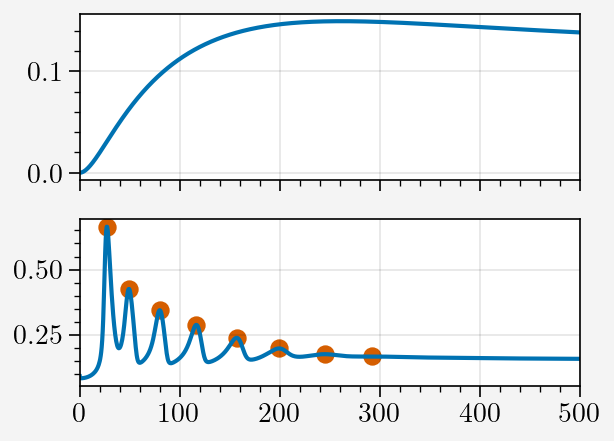

In [74]:
cfg.input_start = 0
cfg.input_max = 0.8
cfg.input_duration = 1000

cfg.kd2 = 1.2
cfg.kd1 = 0.04

run_experiment('pulse', t_f=500, max_step=0.5)
t_peaks, c_peaks = get_peaks()


fig, ax = pplt.subplots(nrows=2, refaspect=3)
ax[0].plot(cfg.t, cfg.Gd1)
ax[1].plot(cfg.t, cfg.c)
ax[1].scatter(t_peaks, c_peaks)

print(c_peaks[1], c_peaks[-1])

cfg.kd1 = 0.02
cfg.kd2 = 1.2

## Parameter effects

### Visualize parameter effects

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


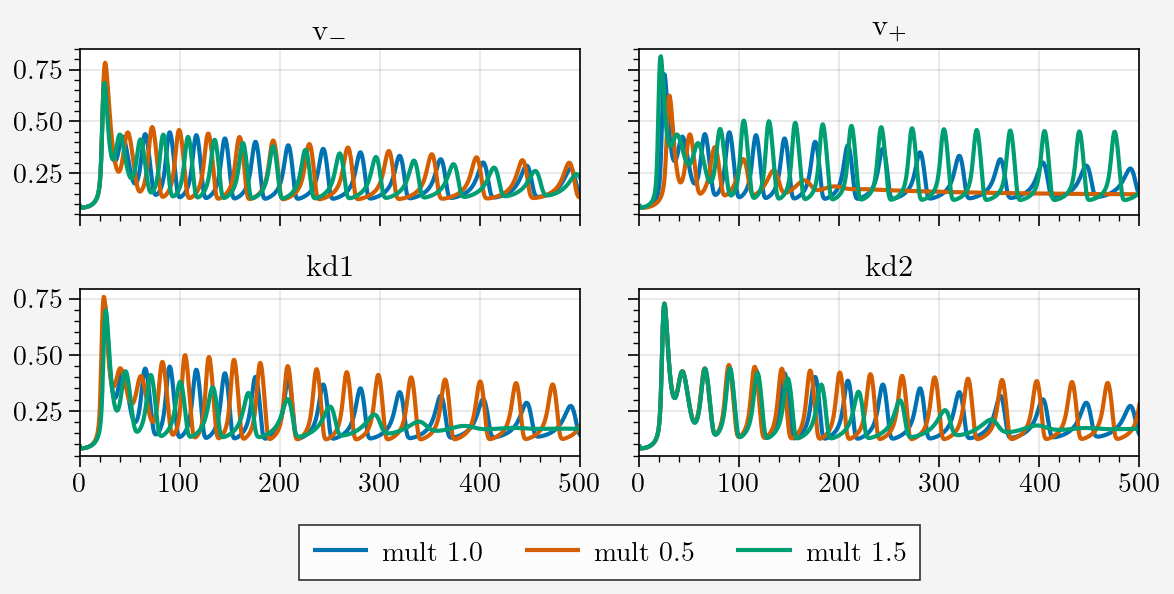

In [35]:
fig, ax = pplt.subplots(nrows=2, ncols=2, refaspect=3)

mults = np.array([1, 0.5, 1.5])

cfg.input_start = 0
cfg.input_max = 0.8
cfg.input_duration = 1000

variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
default_vals = [0.1, 0.005, 0.02, 1.2]


for j, var in enumerate(tqdm(variables)):
    lines = []
    
    for i, reset_var in enumerate(variables):
        setattr(cfg, reset_var, default_vals[i])
    rnge = mults*default_vals[j]
    
    for i, val in enumerate(rnge):
        setattr(cfg, var, val)
        run_experiment('pulse', t_f=500, max_step=0.5)
        t_peaks, c_peaks = get_peaks()
        
        lines.append(ax[j].plot(cfg.t, cfg.c, label=f'mult {mults[i]}'))
    
for i, reset_var in enumerate(variables):
    setattr(cfg, reset_var, default_vals[i])

ax.format(title=labels)
fig.legend(lines, loc='b')

### Visualize ER effect

<a list of 1 Line2D objects>

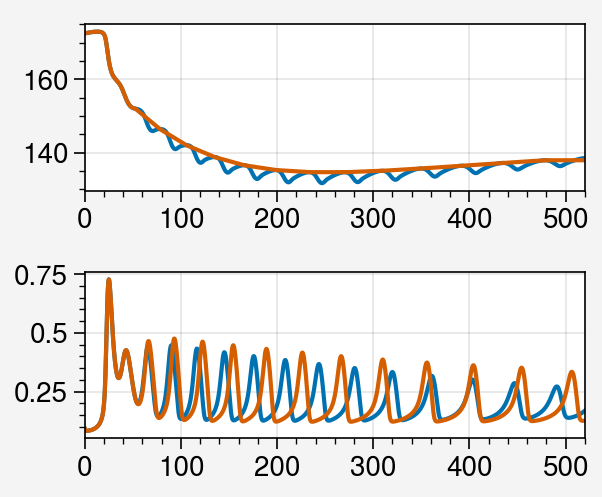

In [14]:
set_init('c_t')
cfg.input_start = 0
cfg.input_max = 0.8
cfg.input_duration = 1000

fig, ax = pplt.subplots(refaspect=3, nrows=2, sharex=False, sharey=False)

run_experiment('pulse', t_f=520, max_step=0.5)
peaks = scipy.signal.find_peaks(cfg.c_er)[0]
fix_c_er = np.append(cfg.c_er[:peaks[1]-50], cfg.c_er[peaks[1:]])
fix_c_er = np.append(fix_c_er, fix_c_er[-1])
fix_t = np.append(cfg.t[:peaks[1]-50], cfg.t[peaks[1:]])
fix_t = np.append(fix_t, 2000)

ax[0].plot(cfg.t, cfg.c_er)
ax[1].plot(cfg.t, cfg.c)


multipliers = np.linspace(0, 2, 21)

all_t_peaks = []
all_c_peaks = []

mult = 1
inter = scipy.interpolate.interp1d(fix_t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('pulse', t_f=520, max_step=0.5, fix_c_er_func=inter)

ax[0].plot(cfg.t, cfg.c_er)
ax[1].plot(cfg.t, cfg.c)


### Parameter effect data collection

In [65]:
cfg.input_start = 0
cfg.input_max = 0.8
cfg.input_duration = 1000

variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
default_vals = [0.1, 0.005, 0.02, 1.2]
multipliers = np.linspace(0, 2, 21)

set_init('c_t')

all_t_peaks = {}
all_c_peaks = {}
for var in variables:
    all_t_peaks[var] = []
    all_c_peaks[var] = []


for j, var in enumerate(tqdm(variables)):
    for i, reset_var in enumerate(variables):
        setattr(cfg, reset_var, default_vals[i])
    rnge = multipliers*default_vals[j]
    
    for val in rnge:
        setattr(cfg, var, val)
        run_experiment('pulse', t_f=500, max_step=0.5)
        
        t_peaks, c_peaks = get_peaks()
        
        all_t_peaks[var].append(t_peaks)
        all_c_peaks[var].append(c_peaks)
        
for i, reset_var in enumerate(variables):
    setattr(cfg, reset_var, default_vals[i])

pickle.dump([all_t_peaks, all_c_peaks], open('data/plot_data/falloff/2.1_oscillation_falloffs', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.55s/it]


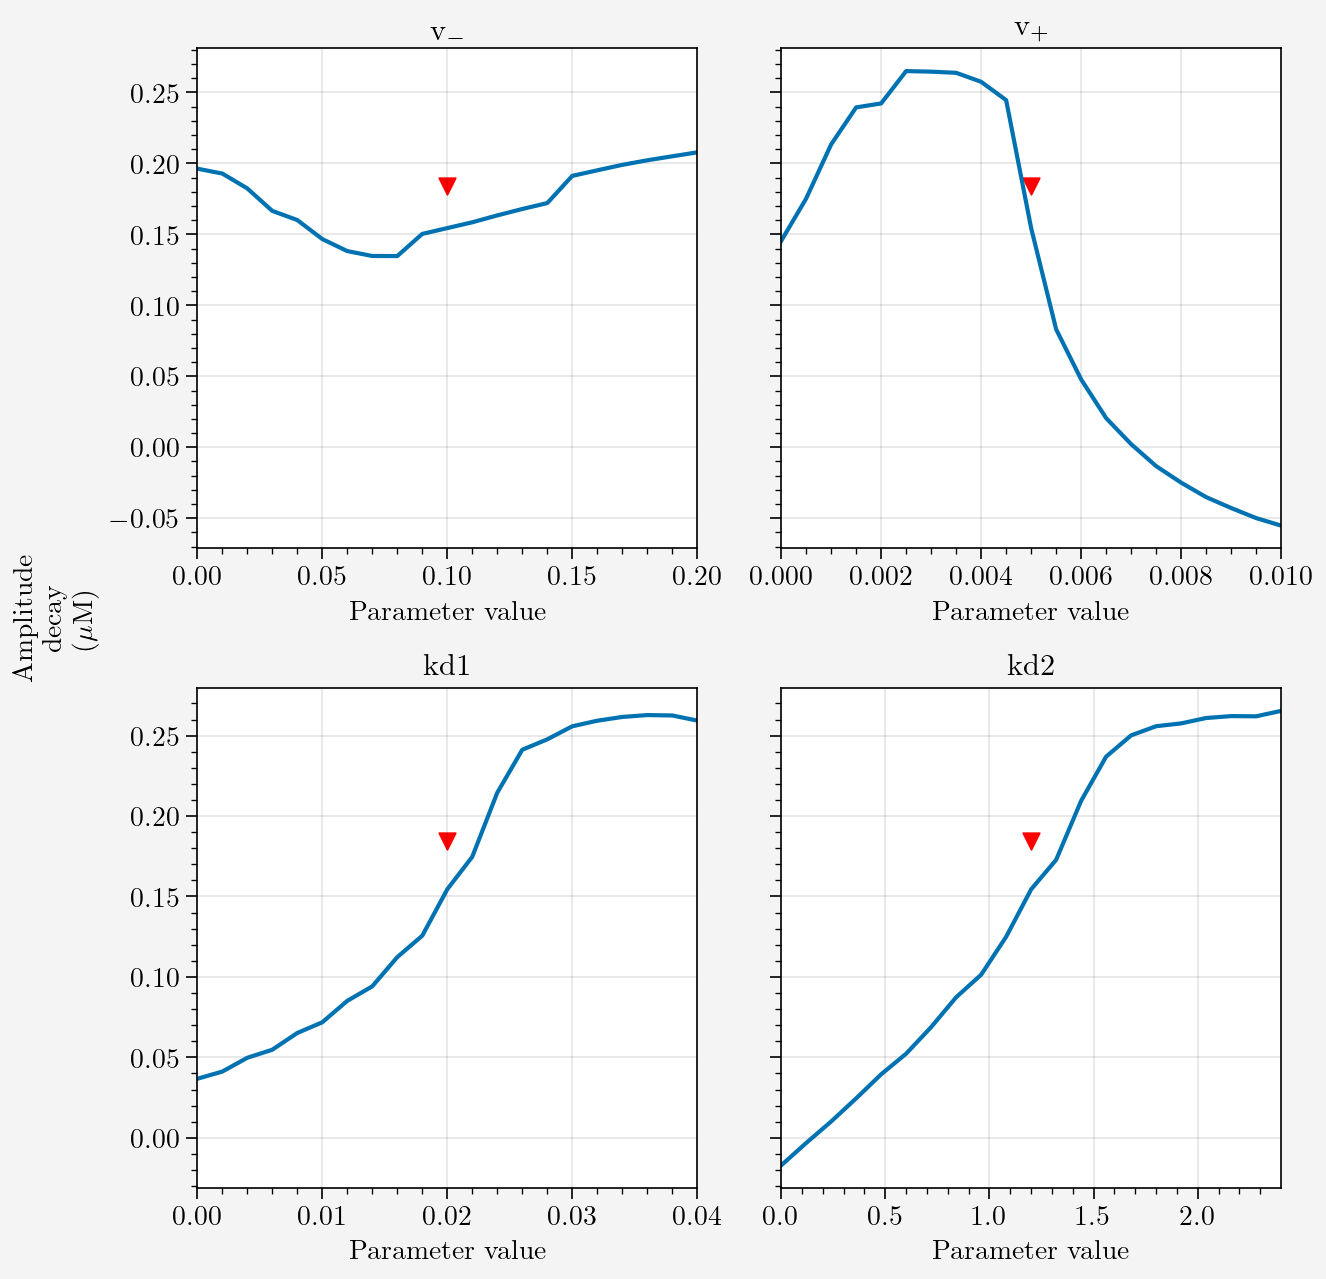

In [66]:
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
default_vals = [0.1, 0.005, 0.02, 1.2]


# decays = pickle.load(open('data/plot_data/falloff/2.1_oscillation_var', 'rb'))
all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.1_oscillation_falloffs', 'rb'))
# multipliers = np.linspace(0, 5, 51)
multipliers = np.linspace(0, 2, 21)

fig, ax = pplt.subplots(nrows=2, ncols=2, sharex=False)

for i, var in enumerate(variables):
    x = multipliers * default_vals[i]
    y = []
    for j in range(len(multipliers)):
        t_peaks = all_t_peaks[var][j]
        c_peaks = all_c_peaks[var][j]
        y.append(c_peaks[1] - c_peaks[-1])
    
    ax[i].plot(x, y)
    ax[i].scatter(multipliers[10]*default_vals[i], y[10]+0.03,
                 c='red', marker='v')

ax.format(xlabel='Parameter value', ylabel='Amplitude\n decay\n ($\mu$M)',
          yrotation=0, title=labels)

### Parameter effect with fixed c_er time course

For consistency with ER plot, recollect same data using fixed c_er

In [15]:
'''Get c_er time course'''

set_init('c_t')
cfg.input_start = 0
cfg.input_max = 0.8
cfg.input_duration = 1000

run_experiment('pulse', t_f=520, max_step=0.5)
peaks = scipy.signal.find_peaks(cfg.c_er)[0]
fix_c_er = np.append(cfg.c_er[:peaks[1]-50], cfg.c_er[peaks[1:]])
fix_c_er = np.append(fix_c_er, fix_c_er[-1])
fix_t = np.append(cfg.t[:peaks[1]-50], cfg.t[peaks[1:]])
fix_t = np.append(fix_t, 2000)

mult = 1
inter = scipy.interpolate.interp1d(fix_t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))

'''Run data collection'''

cfg.input_start = 0
cfg.input_max = 0.8
cfg.input_duration = 1000

variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
default_vals = [0.1, 0.005, 0.02, 1.2]
multipliers = np.linspace(0, 2, 21)

set_init('c_t')

all_t_peaks = {}
all_c_peaks = {}
for var in variables:
    all_t_peaks[var] = []
    all_c_peaks[var] = []


for j, var in enumerate(tqdm(variables)):
    for i, reset_var in enumerate(variables):
        setattr(cfg, reset_var, default_vals[i])
    rnge = multipliers*default_vals[j]
    
    for val in rnge:
        setattr(cfg, var, val)
        run_experiment('pulse', t_f=500, max_step=0.5, fix_c_er_func=inter)
        
        t_peaks, c_peaks = get_peaks()
        
        all_t_peaks[var].append(t_peaks)
        all_c_peaks[var].append(c_peaks)
        
for i, reset_var in enumerate(variables):
    setattr(cfg, reset_var, default_vals[i])

pickle.dump([all_t_peaks, all_c_peaks], open('data/plot_data/falloff/2.1_oscillation_falloffs_fixedcer', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]


## ER depletion effects

In [82]:
cfg.input_start = 0
cfg.input_max = 0.8
cfg.input_duration = 1000

set_init('c_t')

run_experiment('pulse', t_f=500, max_step=0.5)
peaks = scipy.signal.find_peaks(cfg.c_er)[0]
fix_c_er = np.append(cfg.c_er[:peaks[1]-50], cfg.c_er[peaks[1:]])
fix_c_er = np.append(fix_c_er, fix_c_er[-1])
fix_t = np.append(cfg.t[:peaks[1]-50], cfg.t[peaks[1:]])
fix_t = np.append(fix_t, 2000)

multipliers = np.linspace(0, 2, 21)

all_t_peaks = []
all_c_peaks = []

for mult in tqdm(multipliers):
    inter = scipy.interpolate.interp1d(fix_t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    run_experiment('pulse', t_f=500, max_step=0.5, fix_c_er_func=inter)
    t_peaks, c_peaks = get_peaks()

    all_t_peaks.append(t_peaks)
    all_c_peaks.append(c_peaks)

pickle.dump([all_t_peaks, all_c_peaks], open('data/plot_data/falloff/2.2_er_oscillation_falloffs', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.86it/s]


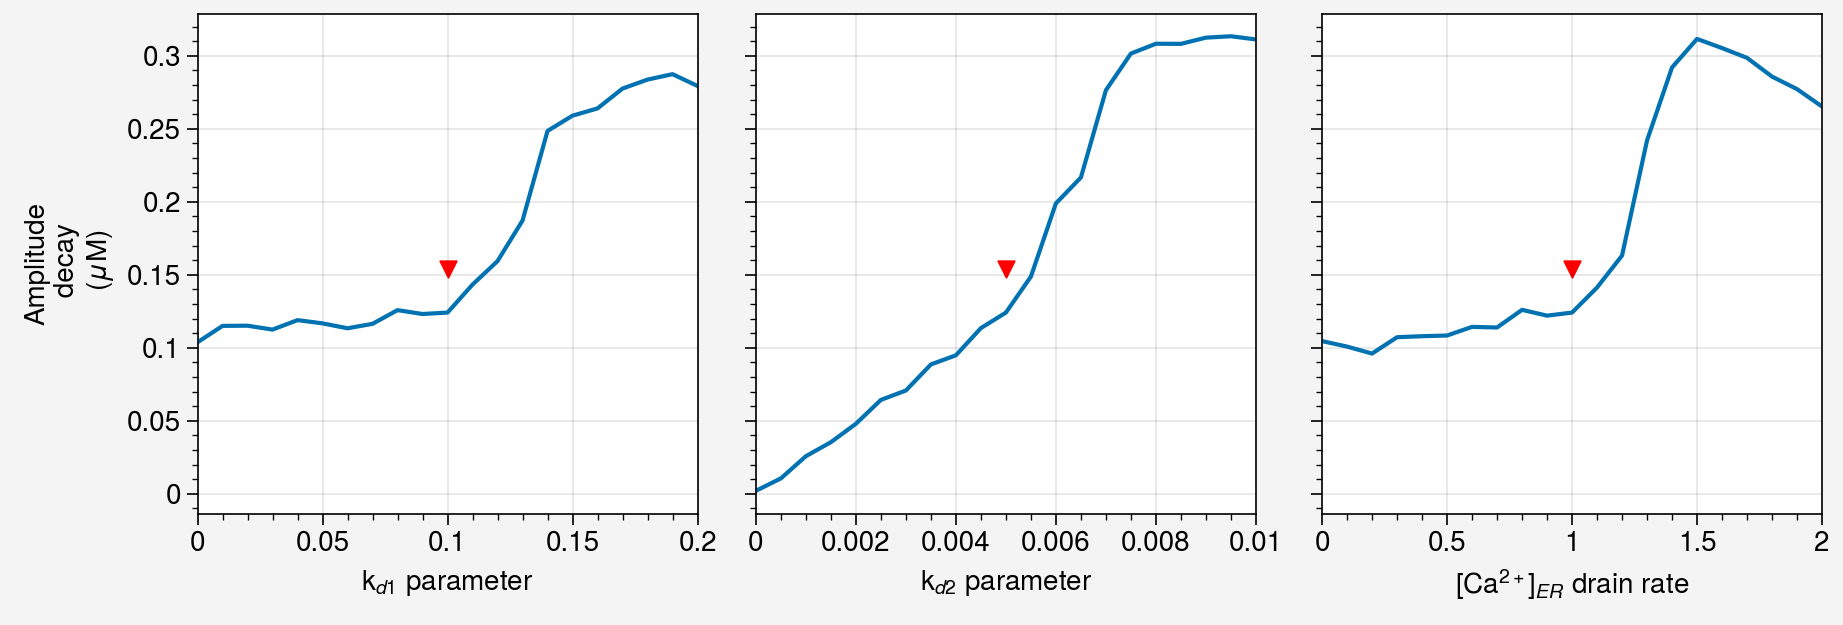

In [21]:
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
default_vals = [0.1, 0.005, 0.02, 1.2]


# decays = pickle.load(open('data/plot_data/falloff/2.1_oscillation_var', 'rb'))
# all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.1_oscillation_falloffs', 'rb'))
all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.1_oscillation_falloffs_fixedcer', 'rb'))
# multipliers = np.linspace(0, 5, 51)
multipliers = np.linspace(0, 2, 21)

fig, ax = pplt.subplots(ncols=3, sharex=False)

# Plot parameter effects
plot_vars = ['kd1', 'kd2']
plot_labels = ['kd1', 'kd2']
for i, var in enumerate(plot_vars):
    x = multipliers * default_vals[i]
    y = []
    for j in range(len(multipliers)):
        t_peaks = all_t_peaks[var][j]
        c_peaks = all_c_peaks[var][j]
        y.append(np.max(c_peaks[1:]) - c_peaks[-1])
    
    ax[i].plot(x, y)
    ax[i].scatter(multipliers[10]*default_vals[i], y[10]+0.03,
                 c='red', marker='v')

# Plot ER depletion effect
all_t_peaks, all_c_peaks = pickle.load(open('data/plot_data/falloff/2.2_er_oscillation_falloffs', 'rb'))
x = multipliers
y = []
for j in range(len(multipliers)):
    t_peaks = all_t_peaks[j]
    c_peaks = all_c_peaks[j]
    y.append(np.max(c_peaks[1:]) - c_peaks[-1])
ax[2].plot(x, y)
ax[2].scatter(multipliers[10], y[10]+0.03, c='red', marker='v')
    
ax.format(ylabel='Amplitude\n decay\n ($\mu$M)',
          yrotation=0)
ax[0].format(xlabel=r'k$_{d1}$ parameter')
ax[1].format(xlabel=r'k$_{d2}$ parameter')
ax[2].format(xlabel=r'[Ca$^{2+}$]$_{ER}$ drain rate')